In [1]:
import configparser
import random
import numpy as np
import tensorflow as tf
from sklearn.metrics import roc_auc_score, average_precision_score
from keras.models import load_model
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, Callback
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.models import load_model, Model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, \
                        Input, Dense, GlobalAveragePooling2D, Dropout
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.utils import to_categorical
from collections import Counter
import keras.optimizers
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
import glob, os
import tensorflow as tf
import pandas as pd
from random import shuffle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import roc_auc_score, average_precision_score, mean_squared_error, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
import pandas as pd
from pycausal import search as s
from pycausal.pycausal import pycausal as pc
from collections import defaultdict
from numpy.polynomial.polynomial import polyfit  
from scipy.stats import pearsonr
from pylab import text
from pycausal import prior as p
import itertools

# select your GPU Here
os.environ["CUDA_VISIBLE_DEVICES"]="" #Comment this line out if you want all GPUS (2 hehe)

# python full-display web browser
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


def gen_data(mean = 0, var = 1, SIZE = 20000):
    a = np.random.normal(mean, var, SIZE)
    b = a + np.random.normal(mean, var, SIZE)
    c =  a + b + np.random.normal(mean, var, SIZE)
    return pd.DataFrame({'a' : a,'b' : b, 'c' : c})

def make_categorical(df, complete_df, categoricals):   
    retval = None
    for key in df.columns:
        if retval is not None:
            if key in categoricals:
                retval = np.concatenate((retval, to_categorical(df[key], len(complete_df[key].unique()))), axis = 1)
            else:
                retval = np.concatenate((retval, df[key].values[...,np.newaxis]), axis = 1)
        else:
            if key in categoricals:
                retval = to_categorical(df[key], len(complete_df[key].unique()))
            else:
                retval = np.expand_dims(df[key], axis = 1)
    return retval
num_models = 100
           
pc = pc()
pc.start_vm(java_max_heap_size = '5000M')
tetrad = s.tetradrunner()

inputs = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
target = ['Outcome']
categoricals = [] 

/home/tkyono/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/tkyono/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
df = pd.read_csv('~/Desktop/Kaggle/diabetes.csv')
# Prior knowledge knows that the test prep comes before the outcome.
df.head()

def normalize(a):
    return (a - np.min(a)) / (np.max(a) - np.min(a))

df['Pregnancies'] = normalize(df['Pregnancies'])
df['Glucose'] = normalize(df['Glucose'])
df['BloodPressure'] = normalize(df['BloodPressure'])
df['SkinThickness'] = normalize(df['SkinThickness'])
df['Insulin'] = normalize(df['Insulin'])
df['BMI'] = normalize(df['BMI'])
df['DiabetesPedigreeFunction'] = normalize(df['DiabetesPedigreeFunction'])
df['Age'] = normalize(df['Age'])
original_df = df.copy()
len(df)

768

In [3]:
len(df[df['Pregnancies'] == 0.0])

111

[[512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [51

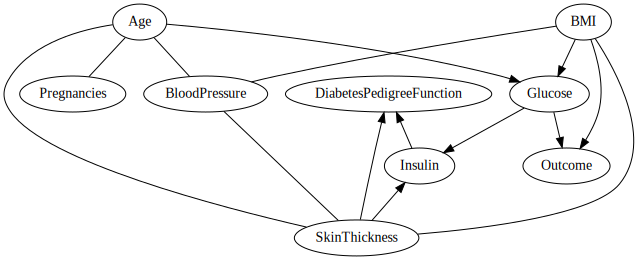

In [4]:
import pydot
from IPython.display import SVG
def examine_graph_continuous(df, prior = None):
    tetrad.run(algoId = 'fges', dfs = df,  scoreId = 'sem-bic', dataType = 'continuous',
               structurePrior = 1.0, samplePrior = 1, maxDegree = -1, maxPathLength = -1, priorKnowledge = prior,
               completeRuleSetUsed = False, faithfulnessAssumed = True, verbose = True,
               )
    return tetrad.getTetradGraph()

def examine_graph_mixed(df, prior = None):
    tetrad.run(algoId = 'fges', dfs = df, scoreId = 'cond-gauss-bic', 
           priorKnowledge = prior, dataType = 'mixed', numCategoriesToDiscretize = 9, 
           structurePrior = 1.0, maxDegree = -1, faithfulnessAssumed = True, verbose = True)

    return tetrad.getTetradGraph()

def examine_graph_discrete(df, prior = None):
    tetrad.run(algoId = 'fges', dfs = df, scoreId = 'bdeu', priorKnowledge = prior, dataType = 'discrete',
               structurePrior = 1.0, samplePrior = 1.0, maxDegree = -1, faithfulnessAssumed = True, verbose = True)
    return tetrad.getTetradGraph()
    
def get_model(dense, dropouts, inputs):
    # dense is an ordered list of the number of dense neurons like [1024, 2048, 1024]
    # dropouts is an ordered list of the dropout masks like [0.2, 0.3, 0.4]
    inputs = keras.Input(shape = (inputs,))
    x = keras.layers.Dense(dense[0], activation = 'relu', kernel_initializer = 'he_normal')(inputs)
    x = keras.layers.Dropout(dropouts[0])(x, training=True)
    for den, drop in zip(dense[1:], dropouts[1:]):
        x = keras.layers.Dense(den, activation = 'relu', kernel_initializer = 'he_normal')(x)
        x = keras.layers.Dropout(drop)(x, training=True)
    outputs = keras.layers.Dense(2, activation = 'softmax', kernel_initializer = 'he_normal')(x)
    model = keras.Model(inputs, outputs)
    return model

def get_bic(df, prior, penalty = 2):

    tetrad.run(algoId = 'fges', dfs = df, scoreId = 'cond-gauss-bic', 
           priorKnowledge = prior, dataType = 'mixed', numCategoriesToDiscretize = 9,
           structurePrior = 1.0, maxDegree = -1, faithfulnessAssumed = True, verbose = True,
              penalty = 200)
    
    BIC = tetrad.getTetradGraph().getAllAttributes().toString()
    BIC = float(BIC.split('=')[-1].split('}')[0])
    return BIC #/ len(df)    

tempForbid = p.ForbiddenWithin(['outcome'])
temporal = [inputs, target]

prior = p.knowledge( addtemporal = temporal)
#prior = None

g = examine_graph_mixed(df, prior = prior)
dot_str = pc.tetradGraphToDot(g)
graphs = pydot.graph_from_dot_data(dot_str)
svg_str = graphs[0].create_svg()

known_conx = set({})
for i in tetrad.getEdges():
    if ' --> ' in i:
        known_conx.add((i.split(' --> ')[0], i.split(' --> ')[1]))
known_conx

prior = p.knowledge(requiredirect =  list(map(list, known_conx)),)
models = []
model_names = []
randomize = False
if randomize:
    layers = [256, 512, 1024, 2048, 4096]
    for i in range(num_models):
        network = []
        for j in range(3):
            network.append(layers[random.randint(0,len(layers) -1)])
        models.append(network)
        model_names.append('temp/random' + str(i))
    print(models, model_names)    
else:
    model_layers = [512,256]
    for i in range(num_models):
        models.append(model_layers)
        model_names.append('temp/pima' + str(i))

print(models, model_names)
SVG(svg_str)



In [5]:
df = original_df.copy()
len(df[df['Age'] > 0.5])

73

In [ ]:
bestAUC = []
bestBIC = []
bestCOMBO = []

for t in range(10):
    # let's split our df into two by race.  Let's see what happens if we 
    df = original_df.copy()

    #df_test = df[df['Pregnancies'] == 0.0].copy()
    df_test = df[df['Age'] > 0.5].copy()

    #works
    '''
    df_test = df[df['Age'] > 0.4].copy()
    '''

    #slightly
    '''
    df_test = df[df['Age'] < 0.02] #this wasn't much of a difference from distribution
    '''
    print(len(df_test))

    df.drop(df_test.index, inplace = True)
    df_test.reset_index(inplace = True)
    df.sample(frac= 1).reset_index(inplace = True) # this will shuffle and reset index

    x_test = df_test[inputs]
    y_test = df_test[target]

    causal_split = 0.2
    val_split = 0.2
    train_split = 1 - (causal_split + val_split)

    x_causal = df[inputs][-int(causal_split * len(df)) :]
    y_causal = df[target][-int(causal_split * len(df)) :]

    x_val = df[inputs][int(train_split * len(df)):-int(causal_split * len(df))]
    y_val = df[target][int(train_split * len(df)):-int(causal_split * len(df))]

    x_train = df[inputs][:int(train_split * len(df))]
    y_train = df[target][:int(train_split * len(df))]
    len(x_causal), len(y_causal), len(x_val), len(y_val), len(x_train), len(y_train)
    print(len(x_train), len(x_val), len(x_causal), len(x_test))


    x_test_NN = x_test
    x_causal_NN = x_causal
    x_val_NN = x_val
    x_train_NN = x_train


    y_test_NN = make_categorical(y_test, original_df, target)
    y_causal_NN = make_categorical(y_causal, original_df, target)
    y_val_NN = make_categorical(y_val, original_df, target)
    y_train_NN = make_categorical(y_train, original_df, target)



    verbosity = 0



    for idx, model_name in enumerate(model_names):
        #print(model_name)

        if type(models[idx]) is list:
            #clear session
            keras.backend.clear_session() 
            #get model according to specification
            model = get_model(models[idx], [0.2] * len(models), np.shape(x_train_NN)[1])
            callbacks = [ModelCheckpoint(model_name, verbose= verbosity, monitor='val_loss',save_best_only=True), 
                         EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=2, verbose= verbosity, mode='auto')]
            model.compile(optimizer = optimizers.SGD(lr = 0.0001, momentum = 0.9, ), loss='categorical_crossentropy', metrics = ['accuracy'])
            #print(len(X), len(y))
            model.fit(x_train_NN, y_train_NN, epochs = 20, validation_data = (x_val_NN, y_val_NN), callbacks = callbacks, batch_size = 8, verbose = verbosity)
        else:
            models[idx].fit(X,y)




    violation = []
    generalization = []
    metrics = []
    proposed = []
    x_causal.reset_index(drop = True, inplace = True)

    for idx, model_name in enumerate(model_names):
        #print(model_name)
        if type(models[idx]) is list:
            keras.backend.clear_session()
            model = load_model(model_name)
        else:
            model = models[idx]

        y_pred = model.predict(x_test_NN)
        generalization.append(roc_auc_score(y_test,y_pred[:,1]))

        #### CHECK FOR CAUSAL METRIC HERE
        y_causal_pred = model.predict(x_causal_NN)[:,1]
        metrics.append(roc_auc_score(y_causal, y_causal_pred))
        print("AUC = ", roc_auc_score(y_causal, y_causal_pred))
        y_causal_pred[y_causal_pred > 0.5] = 1
        y_causal_pred[y_causal_pred <= 0.5] = 0
        causal_targets = pd.DataFrame(y_causal_pred, columns = target)
        causal_targets.reset_index(drop=True, inplace = True)
        causal_df = x_causal.join(causal_targets)
        print(len(causal_df))



        #print(x_causal.head)
        bic_pred = get_bic(causal_df, prior)
        #print(bic_pred, tetrad.getEdges())
        print(bic_pred)
        found_conx = set({})
        for i in tetrad.getEdges():
            if ' --> ' in i:
                found_conx.add((i.split(' --> ')[0], i.split(' --> ')[1]))
        found_conx

        if found_conx == known_conx:
            proposed.append(bic_pred)
            violation.append(0)
        else:
            print("******Found an error")
            # for now just remove bad model.  Will need to add it to distance metric.
            proposed.append(bic_pred)
            violation.append(1)
            #metrics = metrics[:-1]
            #generalization = generalization[:-1]
    nbest = 10
    total = normalize(metrics) - (normalize(proposed) + np.array(violation))
    #total = normalize(metrics) - normalize(proposed)

    final = pd.DataFrame(np.stack((metrics, proposed, total, generalization), axis = 1), columns = ['metrics', 'proposed', 'combined', 'generalization'])
    print("MSE = ", np.mean(final.nlargest(nbest, 'metrics')['generalization']))
    print("BIC = ", np.mean(final.nlargest(nbest, 'proposed')['generalization']))
    print("COMB = ",np.mean(final.nlargest(nbest, 'combined')['generalization']))
    bestAUC.append(np.mean(final.nlargest(nbest, 'metrics')['generalization']))
    bestBIC.append(np.mean(final.nlargest(nbest, 'proposed')['generalization']))
    bestCOMBO.append(np.mean(final.nlargest(nbest, 'combined')['generalization']))
np.mean(bestAUC), np.mean(bestBIC), np.mean(bestCOMBO)

73
417 139 139 73


Exception ignored in: <bound method TF_Output.<lambda> of <tensorflow.python.pywrap_tensorflow_internal.TF_Output; proxy of <Swig Object of type 'TF_Output *' at 0x7fd4adb57450> >>
Traceback (most recent call last):
  File "/home/tkyono/anaconda3/lib/python3.6/site-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 970, in <lambda>
    __del__ = lambda self: None
KeyboardInterrupt: 


AUC =  0.5038919413919414
139
1096.2033600576485
AUC =  0.5730311355311355
139
1070.1794203244215
******Found an error
AUC =  0.612408424908425
139
1089.5649315617216
AUC =  0.5920329670329672
139
1038.651452543329
AUC =  0.5233516483516484
139
1028.661200938328
AUC =  0.4587912087912088
139
1126.3014091342202
AUC =  0.5947802197802199
139
1029.5376433068864
******Found an error
AUC =  0.5760073260073261
139
1020.9723836757423
AUC =  0.61996336996337
139
1052.1351684019537
******Found an error
AUC =  0.5004578754578755
139
1082.89530639496
AUC =  0.5542582417582418
139
1047.1763121732042
AUC =  0.565018315018315
139
1064.4533523277214
******Found an error
AUC =  0.47138278388278393
139
1047.8120043954086
******Found an error
AUC =  0.48122710622710624
139
1047.6940446514177
******Found an error
AUC =  0.5881410256410257
139
1097.0570287347691
AUC =  0.4423076923076923
139
1090.7148700057983
AUC =  0.521062271062271
139
1010.7482593451609
******Found an error
AUC =  0.5725732600732601
1

1111.7699848756154
******Found an error
AUC =  0.5345695970695971
139
1019.9449933754457
AUC =  0.5590659340659341
139
1091.6486014144252
******Found an error
AUC =  0.510989010989011
139
1055.0337395109289
AUC =  0.5247252747252747
139
1075.0034542450248
AUC =  0.6163003663003663
139
1042.2788296701915
******Found an error
AUC =  0.5190018315018315
139
1049.5836972833317
******Found an error
AUC =  0.6087454212454213
139
1038.8780841639584
******Found an error
AUC =  0.5011446886446886
139
1024.1111146879161
******Found an error
AUC =  0.5897435897435898
139
1075.6346046139063
******Found an error
AUC =  0.6460622710622711
139
1055.6556666014842
******Found an error
AUC =  0.5462454212454213
139
1089.177316691892
******Found an error
AUC =  0.5540293040293041
139
1078.1469494213081
AUC =  0.49702380952380953
139
1045.5572162619499
AUC =  0.5853937728937729
139


In [ ]:
y_train_NN

In [ ]:
original_df = df.copy()
df = original_df.copy()

len(df[df['BMI'] > 0.6])

In [ ]:
x_test

In [ ]:
fig, ax = plt.subplots()
b,m = polyfit(proposed,generalization, 1)
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(proposed,generalization)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
ax.plot(proposed,generalization, '.')
plt.plot(proposed, b + m * np.array(proposed), '-')
ax.set_xlabel("BIC")
ax.set_ylabel("GEN")
fig.savefig('Ex4MSEVsAUS.pdf', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots()
b,m = polyfit(metrics,generalization, 1)
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(metrics,generalization)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
ax.plot(metrics,generalization, '.')
plt.plot(metrics, b + m * np.array(metrics), '-')
ax.set_xlabel("MSE")
ax.set_ylabel("GEN")
fig.savefig('Ex4MSEVsAUS.pdf', bbox_inches='tight')
plt.show()


total = normalize(metrics) - (normalize(proposed) + np.array(violation))
fig, ax = plt.subplots()
b,m = polyfit(total,generalization, 1)
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(total,generalization)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
ax.plot(total,generalization, '.')
plt.plot(total, b + m * np.array(total), '-')
ax.set_xlabel("MSE")
ax.set_ylabel("GEN")
fig.savefig('Ex4MSEVsAUS.pdf', bbox_inches='tight')
plt.show()


In [ ]:
nbest = 5
final = pd.DataFrame(np.stack((metrics, proposed, total, generalization), axis = 1), columns = ['metrics', 'proposed', 'combined', 'generalization'])
print("MSE = ", np.mean(final.nlargest(nbest, 'metrics')['generalization']))
print("BIC = ", np.mean(final.nlargest(nbest, 'proposed')['generalization']))
print("COMB = ",np.mean(final.nlargest(nbest, 'combined')['generalization']))

In [ ]:
model = load_model('temp/pima50')
roc_auc_score(y_val, model.predict(x_train_NN)[:,1])